In [1]:
import re
import timeit
import math

from imgdataconvertcodegen.image_data import get_input_image_and_expected_output

def execute_time_cost(source, target, conversion, repeat_count=10):
    try:
        source_image, _ = get_input_image_and_expected_output(source, target)
    except Exception as e:
        # If the conversion function cannot be executed, return infinity, for example, there is no tensorflow gpu
        # support in the environment.
        return math.inf
    setup = f"{conversion[0]}\n{conversion[1]}"
    func_name = re.search(r'(?<=def )\w+', conversion[1]).group(0)
    code = f"actual_image = {func_name}(source_image)"
    try:
        execution_time = timeit.timeit(stmt=code, setup=setup, number=repeat_count, globals=locals())
    except Exception as e:
        raise RuntimeError(f'{e}, \ncode is {code}\nsetup is {setup}')
    return execution_time / repeat_count

2024-04-03 17:24:28.960869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 17:24:29.715579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def is_code_exec_on_cpu(edge):
    return edge[0]['device'] == 'cpu' and edge[1]['device'] == 'cpu'

def hist(data, title, interval=0.1):
    bins = np.arange(0, max(data) + interval, interval)
    n, bins, patches = plt.hist(data, bins=bins, alpha=0.7, rwidth=0.85)
    for patch in patches:
        height = patch.get_height()
        plt.annotate(f'{int(height)}',
                     (patch.get_x() + patch.get_width() / 2, height),
                     textcoords="offset points",
                     xytext=(0,5),
                     ha='center')
    plt.title(title)
    plt.xlabel('Execution Time (s)')
    plt.ylabel('Number')
    plt.show()

In [3]:
from imgdataconvertcodegen import _code_generator, _constructor

kg = _code_generator.knowledge_graph
print(kg)

Knowledge Graph with 553 nodes and 6472 edges.


2024-04-03 17:24:32.520698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 17:24:32.521977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 17:24:32.522251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 17:24:32.523682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 17:24:32.523996: I external/local_xla/xla/stream_executor

The range of execution time from 2.900000254157931e-07 to 0.0025923032999344287


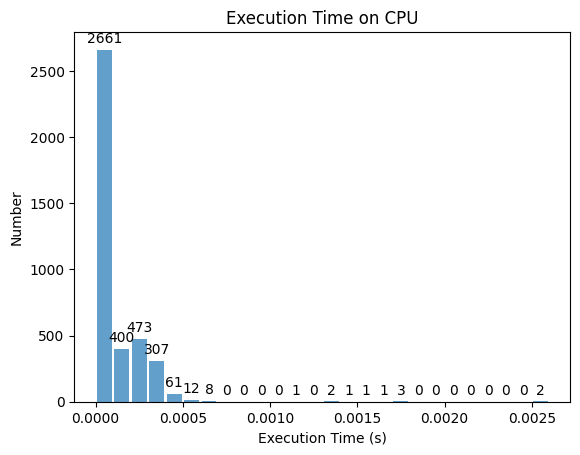

In [4]:
times = []
for edge in kg.edges:
    if is_code_exec_on_cpu(edge):
        conversion = kg.get_edge_data(edge[0], edge[1])['conversion']
        times.append(execute_time_cost(edge[0], edge[1], conversion))
print(f'The range of execution time from {min(times)} to {max(times)}')
hist(times, "Execution Time on CPU", 0.0001)

The range of execution time from 1.889999839477241e-06 to 0.006680462999975134


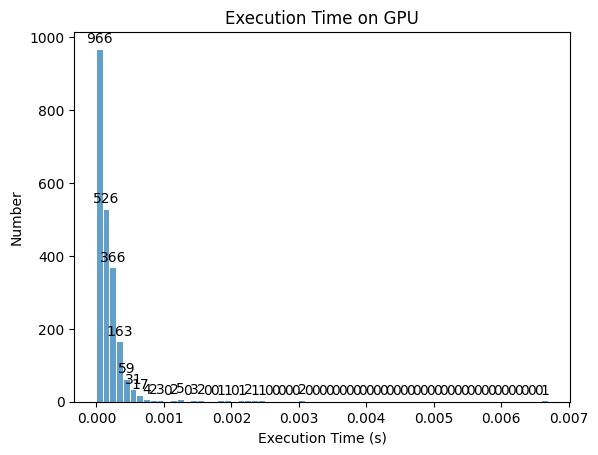

In [7]:
import math

def is_code_exec_on_gpu(edge):
    return edge[0]['device'] == 'gpu' and edge[1]['device'] == 'gpu'

times = []
for edge in kg.edges:
    if is_code_exec_on_gpu(edge):
        conversion = kg.get_edge_data(edge[0], edge[1])['conversion']
        times.append(execute_time_cost(edge[0], edge[1], conversion))
print(f'The range of execution time from {min(times)} to {max(times)}')
hist(times, "Execution Time on GPU", 0.0001)

The range of execution time from 2.899998435168527e-07 to 0.0022074529999372315


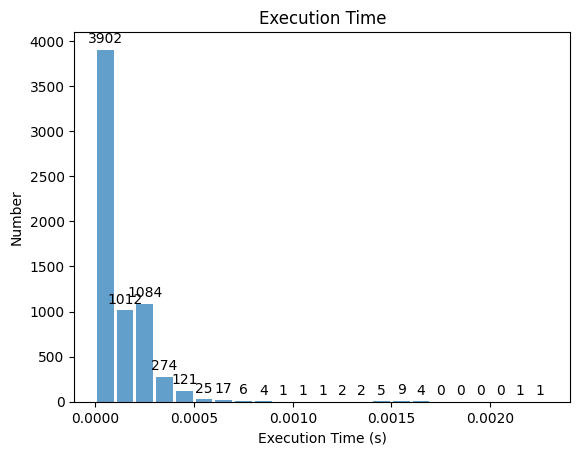

In [6]:
times = []
for edge in kg.edges:
    conversion = kg.get_edge_data(edge[0], edge[1])['conversion']
    times.append(execute_time_cost(edge[0], edge[1], conversion))

print(f'The range of execution time from {min(times)} to {max(times)}')
hist(times, "Execution Time", 0.0001)